In [2]:
import os

from numpy.ma.core import filled
from skimage import io
import numpy as np  

# paths to data
path_closed = "./data/train/Closed_Eyes"
path_open = "./data/train/Open_Eyes"

# list of filenames
closed_eyes_files = os.listdir(path_closed)
open_eyes_files = os.listdir(path_open)

In [3]:
# images stored here
closed_eyes = []
open_eyes = []

# images loaded here
for file_name in closed_eyes_files:
    path = path_closed + "/" + file_name
    closed_eyes.append(io.imread(path))

for file_name in open_eyes_files:
    path = path_open + "/" + file_name
    open_eyes.append(io.imread(path))

# get sizes of the pictures in the array
closed_eyes_sizes = [image.shape[0] for image in closed_eyes]
open_eyes_sizes = [image.shape[0] for image in open_eyes]

## RESIZE

In [4]:
from skimage.transform import resize


median_size = (np.median(open_eyes_sizes + closed_eyes_sizes))

# resize to target size, equal to mean value for all sizes
target_size = (int(median_size), int(median_size))
open_resized = []
closed_resized = []
 
for img in closed_eyes:
    closed_resized.append(resize(img, target_size, anti_aliasing=True))

for img in open_eyes:
    open_resized.append(resize(img, target_size, anti_aliasing=True))

closed_resized = np.array(closed_resized)
open_resized = np.array(open_resized)

In [5]:
X = np.concatenate((closed_resized.copy(), open_resized.copy()), axis=0)
y = np.concatenate((np.zeros(2000), np.ones(2000))) # 0 for closed, 1 for open eye

## SPLIT

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV

# stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

# 4:1
# 3200 in train set, 1600 open 1600 closed
print(X_train.shape)

(3200, 100, 100)


## DATA AUGMENTATION

In [7]:
test_tilt_size = 100 # 200 more pictures for light and dark
train_tilt_size = 100 # 400 more pictures for light and dark

np.random.seed(42)

test_light_indexes = np.random.choice(len(X_test), size = test_tilt_size, replace=False)
test_dark_indexes = np.random.choice(len(X_test), size = test_tilt_size, replace=False)

train_light_indexes = np.random.choice(len(X_train), size = train_tilt_size, replace=False)
train_dark_indexes = np.random.choice(len(X_train), size = train_tilt_size, replace=False)

In [8]:
X_test_dark = X_test[test_dark_indexes]
X_test_light = X_test[test_light_indexes]
y_test_dark = y_test[test_dark_indexes]
y_test_light = y_test[test_light_indexes]

X_train_dark = X_train[train_dark_indexes]
X_train_light = X_train[train_light_indexes]
y_train_dark = y_train[train_dark_indexes]
y_train_light = y_train[train_light_indexes]

print(len(X_test_light) + len(X_test_dark)) 
print(len(X_train_dark) + len(X_train_light))

200
200


In [9]:
desired_mean = 0.95
for i in range(len(X_test_light)):
    current_mean = np.mean(X_test_light[i])
    X_test_light[i] = np.clip(X_test_light[i] + (desired_mean - current_mean), 0, 1)
    
for i in range(len(X_train_light)):
    current_mean = np.mean(X_train_light[i])
    X_train_light[i] = np.clip(X_train_light[i] + (desired_mean - current_mean), 0, 1)

X_test_dark = np.clip(X_test_dark * 0.9, 0, 1)
X_train_dark = np.clip(X_train_dark * 0.9, 0, 1)


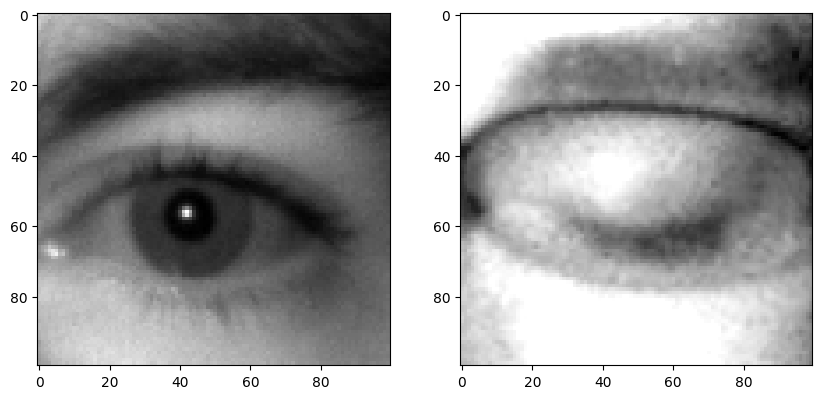

In [12]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(X_test_dark[0], cmap="gray")
ax2.imshow(X_test_light[0], cmap="gray")

## BLUR

In [13]:
test_blur_size = 50
train_blur_size = 200

test_blur_indexes = np.random.choice(len(X_test), size = test_blur_size, replace=False)
train_blur_indexes = np.random.choice(len(X_train), size = train_blur_size, replace=False)

In [14]:
X_test_blur = X_test[test_blur_indexes]
y_test_blur = y_test[test_blur_indexes]

X_train_blur = X_train[train_blur_indexes]
y_train_blur = y_train[train_blur_indexes]

print(len(X_test_blur))
print(len(X_train_blur))

50
200


In [15]:
def pixelate(image):
    pixelated_image = np.copy(image)
    
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            neighborhood = image[i-1:i+4, j-1:j+4].astype(float)
            pixelated_image[i, j] = np.mean(neighborhood)
            
    return pixelated_image

In [16]:
for i in range(len(X_test_blur)):
   X_test_blur[i] = pixelate(X_test_blur[i])
   
for i in range(len(X_train_blur)):
    X_train_blur[i] = pixelate(X_train_blur[i])

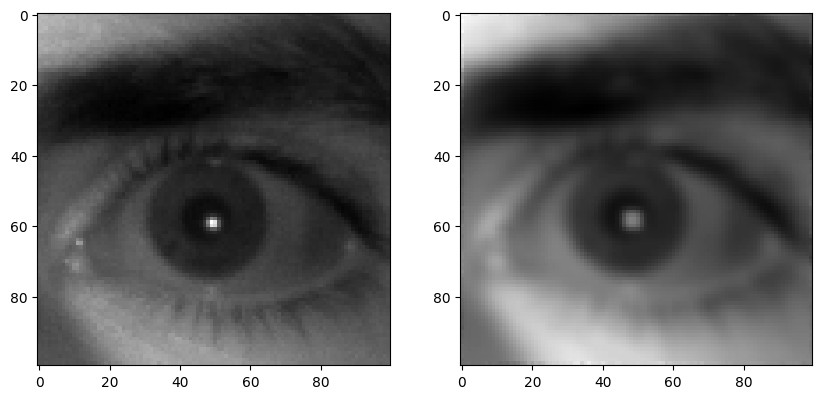

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax2.imshow(X_test_blur[0], cmap="gray")
ax1.imshow(X_test[test_blur_indexes[0]], cmap="gray")

    ## CONCATENATE

## ROTATE

In [18]:
test_rotation_size = 50
train_rotation_size = 200

test_rotation_indexes = np.random.choice(len(X_test), size = test_rotation_size, replace=False)
train_rotation_indexes = np.random.choice(len(X_train), size = train_rotation_size, replace=False)

In [19]:
X_test_rotate = X_test[test_rotation_indexes]
y_test_rotate = y_test[test_rotation_indexes]

X_train_rotate = X_train[train_rotation_indexes]
y_train_rotate = y_train[train_rotation_indexes]

In [20]:
for i in range(len(X_test_rotate)):
    X_test_rotate[i] = np.rot90(X_test_rotate[i], k=1)

for i in range(len(X_train_rotate)):
    X_train_rotate[i] = np.rot90(X_train_rotate[i], k=1)

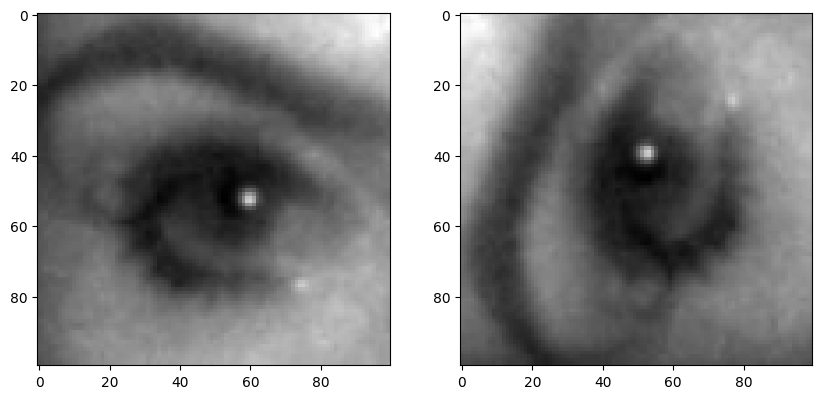

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax2.imshow(X_test_rotate[0], cmap="gray")
ax1.imshow(X_test[test_rotation_indexes[0]], cmap="gray")

In [77]:
X_test = np.concatenate((X_test, X_test_dark, X_test_light, X_test_blur), axis=0)
y_test = np.concatenate((y_test, y_test_dark, y_test_light, y_test_blur), axis=0)

X_train = np.concatenate((X_train, X_train_dark, X_train_light, X_train_blur), axis=0)
y_train = np.concatenate((y_train, y_train_dark, y_train_light, y_train_blur), axis=0)

print(len(X_test))
print(len(X_train))

1050
3600


## PCA

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

In [83]:
X_flattened = X_train.reshape(X_train.shape[0], -1)
print(X_flattened.shape)

X_test_flattened = X_test.reshape(X_test.shape[0], -1)
print(X_test_flattened.shape)

(3600, 10000)
(1050, 10000)


In [84]:
X_train_flattened = pca.fit_transform(X_flattened)
X_test_flattened = pca.transform(X_test_flattened)

In [85]:
print(X_test_flattened.shape)
print(X_train_flattened.shape)

(1050, 11)
(3600, 11)


In [86]:
from sklearn.preprocessing import StandardScaler

# mean = 0
# standard deviation = 1

scaler = StandardScaler()
X_train_flattened = scaler.fit_transform(X_train_flattened)
X_test_flattened = scaler.transform(X_test_flattened) # NOT FIT TRANSFORM
print(np.std(X_train_flattened))
print(abs(round(np.mean(X_train_flattened), 17)))

1.0
0.0


## RANDOM FOREST

In [87]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42, n_jobs=1, max_leaf_nodes=80, n_estimators=600)

In [88]:
rnd_clf.fit(X_train_flattened, y_train)


RandomForestClassifier(max_leaf_nodes=80, n_estimators=600, n_jobs=1,
                       random_state=42)

In [89]:
score = rnd_clf.score(X_test_flattened, y_test)
print(score)

0.9876190476190476
